# NIH CXR Database Image Classifier using VGG16 and Random Forrest

In [1]:
"""
Feature Extractor: NN pretained on ImageNet
Output layer(s): SVM - traditional machine learning classifiers
Inspired by Sreenivas Bhattiprolu's classifier of similar approach
https://github.com/bnsreenu/python_for_microscopists/blob/master/158_classification_CNN_RF.py
"""
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
# import glob
import cv2
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
# from keras.models import Model, Sequential
# from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
# from keras.layers.normalization import BatchNormalization
import os
import seaborn as sns
from sklearn import preprocessing, metrics
# from sklearn.ensemble import RandomForestClassifier

In [2]:
#UTILITY FUCTION FOR TIME STAMPS
import calendar, time
from datetime import datetime
def getTimeStamp():
  current_GMT = time.gmtime()  # Current GMT time in a tuple format
  ts = calendar.timegm(current_GMT)   # ts stores timestamp
  date_time = datetime.fromtimestamp(ts)
  return date_time.strftime("%m%d-%H%M%S")  # convert timestamp to string in dd-mm-yyyy HH:MM:SS


In [3]:
# SHOW US WHAT YAH GOT
import sys
print(f"GPU: {tf.config.list_physical_devices('GPU')}  ")
print(f"CPU: {tf.config.list_physical_devices('CPU')}  ")
print(f"Python {sys.version}\nTensorflow{tf.__version__}")

GPU: []  
CPU: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]  
Python 3.10.5 | packaged by conda-forge | (main, Jun 14 2022, 07:03:09) [Clang 13.0.1 ]
Tensorflow2.9.1


In [4]:
# If running on google colab, mount colab drive
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
else:
  print('Not running on CoLab')

Not running on CoLab


In [5]:
WORKING_DIR_TS = os.getcwd()
WORKING_DIR_TS += '/'
if 'google.colab' in str(get_ipython()): #if working on google colab google colab
  WORKING_DIR_TS = '/content/drive/MyDrive/' #this is where files actually reside on google colab (that is on a mounted google drive)
WORKING_DIR_TS

'/Users/white/Documents/AlexProjects/DICOM_OCC_MED/'

In [8]:
# DEFINE CONSTANSTS
SIZE = 512  #Resize images, note original input shape for VGG is (224,244,3)
MAX_NUMBER_OF_EACH_FINDING = 525 #Total number of image for both testing and training
OVER_UNDER_SAMPLE_COUNT =2000
LIMIT_SAMPLE_TO_FINDINGS = ['No Finding' ,'Infiltration','Fibrosis'] #['No Finding' ,'Infiltration','Cardiomegaly' ,'Effusion','Mass','Fibrosis']
# MIN_AGE,MAX_AGE = 18,85
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
EPOCHS=1

DATA GENERATOR FLOW_FROM_DIRECTORY APPROACH (DEPRICATED)

In [19]:
## SET UP DATA GENERATOR AND FLOW_FROM_DIRECTORY
from collections import Counter
train_datagen = ImageDataGenerator(
  rescale=1./255,
  validation_split=VALIDATION_SPLIT,
  # zoom_range=0.2,
)
val_datagen = ImageDataGenerator(
  rescale=1./255,
  validation_split=VALIDATION_SPLIT,
)
train_data_generator = datagen.flow_from_directory(
  'dicom/NIH_subset',
  target_size=(SIZE, SIZE),
  batch_size=BATCH_SIZE,
  shuffle = True,
  class_mode= 'categorical', #'sparse' #',
  classes= LIMIT_SAMPLE_TO_FINDINGS,
  subset="training"
)

val_data_generator = val_datagen.flow_from_directory(
  'dicom/NIH_subset',
  target_size=(SIZE, SIZE),
  batch_size=BATCH_SIZE,
  shuffle = True,
  class_mode= 'categorical', #'sparse' #',
  classes= LIMIT_SAMPLE_TO_FINDINGS,
  subset="validation"
)
## SET UP CLASS WEIGHTS TO ACCOUNT FOR IMBALANCED DATASET
counter = Counter(data_generator.classes)                          
max_val = float(max(counter.values()))  
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}      

TOTAL_SAMPLES=sum(counter.values())
class_weights, counter,  data_generator.class_indices, TOTAL_SAMPLES, data_generator.num_classes


Found 8951 images belonging to 3 classes.
Found 2237 images belonging to 3 classes.


({0: 1.0, 1: 1.0, 2: 8.132716049382717},
 Counter({0: 5270, 1: 5270, 2: 648}),
 {'No Finding': 0, 'Infiltration': 1, 'Fibrosis': 2},
 11188,
 3)

In [17]:
tfds = tf.keras.utils.image_dataset_from_directory('dicom/NIH_subset',
  label_mode='categorical' )
tfds.class_names
tfds.

Found 15387 files belonging to 6 classes.


['Cardiomegaly', 'Effusion', 'Fibrosis', 'Infiltration', 'Mass', 'No Finding']

In [ ]:

# # images, labels = getImagesAndLabels(total_df)

# datagen = ImageDataGenerator(rescale=1./255) #when we flow images, we want them scaled - this fuction can also be used for data augmentation
# generator = datagen.flow_from_directory(
#         WORKING_DIR_TS+'dicom/NIH_subset/',
#         target_size=(SIZE, SIZE),
#         class_mode='categorical')
# # generator.image_shape,generator.class_indices,generator.labels[:5],generator.samples
# generator.next()

In [ ]:
# from sklearn.model_selection import train_test_split
# train_images, test_images, train_labels,  test_labels = train_test_split(images, labels, random_state=0, test_size = 0.2, stratify=labels)
# train_labels[:5]

In [ ]:
# #Show the split between train and test sets.  By setting Straify = Labels it should keep the values proportional
# unique_labels, train_labels_counts = np.unique(train_labels, return_counts=True)
# #Show the split between train and test sets.  By setting Straify = Labels it should keep the values proportional
# unique_labels, train_labels_counts ,np.unique(test_labels, return_counts=True), unique_labels.size


In [ ]:
# encode labels, ie from 'No Finding', 'Fibrosis', ... ====> 0, 1, ...
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(test_labels)
test_labels_encoded = label_encoder.transform(test_labels)
label_encoder.fit(train_labels)
train_labels_encoded = label_encoder.transform(train_labels)
label_encoder.classes_,train_labels[:5],train_labels_encoded[:5]

In [ ]:
#Rename to standard naming conventions
# x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

##### RESCALE AND FORMAT DATA

In [ ]:

# # Normalize pixel values to between 0 and 1
# x_train, x_test = x_train / 255.0, x_test / 255.0
# x_train.shape

In [ ]:
# One hot encode y values for neural network. 
# Not currently used.  Will keep in case want to used in futures.
y_train_one_hot = keras.utils.to_categorical(y_train)
y_test_one_hot = keras.utils.to_categorical(y_test)
y_train_one_hot

##### TRANSFER LEARNING  LOAD PRETRAINED KERAS APPLICATION

In [10]:
#Load model without output classifier/fully connected layers, set input shape to our custom SIZE 
#This will act as a "feature detector"
IMAGE_SHAPE = (SIZE, SIZE)
print(IMAGE_SHAPE)
base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False,  input_shape=(SIZE,SIZE,3), pooling='max')
base_model.trainable = False
inputs = keras.Input(shape=(SIZE, SIZE, 3))
# We make sure that the base_model is running in inference mode here
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
intermediate_outputs = base_model(inputs, training=False)
#base_model.summary()


(512, 512)


2022-08-20 13:17:01.314365: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


##### CREATE OUTPUT LAYERS AND ADD TO THE BASE MODEL

In [11]:
### CREATE A SVM (SUPPORT VECTOR MACHINE) FOR CLASSIFYING
### SVM example: https://github.com/krishnaik06/Complete-Deep-Learning/blob/master/Image%20Classification%20Using%20SVM.ipynb
# # #FLATTEN - MAY NOT BE NEEDED WITH SOME BASE MODELS DEPENDING OUT OUTPUT SHAPE, COULD DO GLOBALMAXPOOLING INSTEAD
# # x = keras.layers.Flatten()(x)
# # # Make Fully Connection Layer
# x = keras.layers.Dense(units=16, activation='relu')(intermediate_outputs)
# # USE LINEAR CLASSIFICATION FOR A BINARY CLASSIFIER
# outputs = keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='linear')(x) 
# # # USE LINEAR CLASSIFICATION FOR A BINARY CLASSIFIER
# # outputs = keras.layers.Dense(XXXXCATEGORYNUMBER, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax')(x) 


### Create a simple final dense NN layer
outputs = tf.keras.layers.Dense( data_generator.num_classes, activation = tf.keras.activations.softmax)(intermediate_outputs)
print("Model outputs categories/labels: ", data_generator.num_classes)

### CREATE OUR FINAL MODEL
model = keras.Model(inputs, outputs)

# #Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
# for layer in model.layers:
# 	layer.trainable = False
model.summary()  #Trainable parameters will be 0

Model outputs categories/labels:  3
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
Total params: 21,808,931
Trainable params: 6,147
Non-trainable params: 21,802,784
_________________________________________________________________


In [12]:
# COMPILING THE CNN
model.compile(
  optimizer = 'adam', 
  loss=tf.keras.losses.CategoricalCrossentropy(),#  logits=TrUe /// loss = 'hinge', 
  metrics = ['accuracy']) #'sparse_categorical_crossentropy'

In [ ]:
# SAVE CHECKPOINTS
# generate path wehere you want to save your checkpoints
checkpoint_path = f"checkpoints/{getTimeStamp()}_weights.h5"
# define a callback that will save the model weights after every epoch 
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath=checkpoint_path,
  #save_weights_only=True,
  monitor='val_accuracy',
  mode='max',
  verbose=1,
  save_best_only=True)

In [20]:
#Train the CNN model, note:batch size is set in the generator
steps_per_epoch = int(TOTAL_SAMPLES/BATCH_SIZE)
print(steps_per_epoch);
history = model.fit(
  train_data_generator,
  validation_data=val_data_generator,
  epochs=EPOCHS, 
  steps_per_epoch=steps_per_epoch,
  class_weight=class_weights,
  # validation_data = (x_test, y_test), 
  callbacks=[model_checkpoint_callback])

349
15/15 [==============================] - ETA: 0s - loss: 2.6411 - accuracy: 0.3292 
Epoch 1: val_accuracy improved from -inf to 0.31068, saving model to checkpoints/0820-131717_weights.h5
15/15 [==============================] - 1318s 93s/step - loss: 2.6411 - accuracy: 0.3292 - val_loss: 1.5224 - val_accuracy: 0.3107


In [21]:
## load model weights from file
if(False): ##I don't want this to run noramlly
  new_model = keras.models.load_model(checkpoint_path)
    # assert_allclose(model.predict(x_train), new_model.predict(x_train), 1e-5)
  # continue fitting the model
  # generate a new path wehere you want to save your checkpoints
  checkpoint_path = f"checkpoints/{getTimeStamp()}_weights.h5"
  # define a callback wutg the new path name
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True)
  ##RESTART TRAINING
  history = new_model.fit( 
    x_train, y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_data = (x_test, y_test), 
    callbacks=[model_checkpoint_callback])
model= keras.models.load_model(checkpoint_path)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


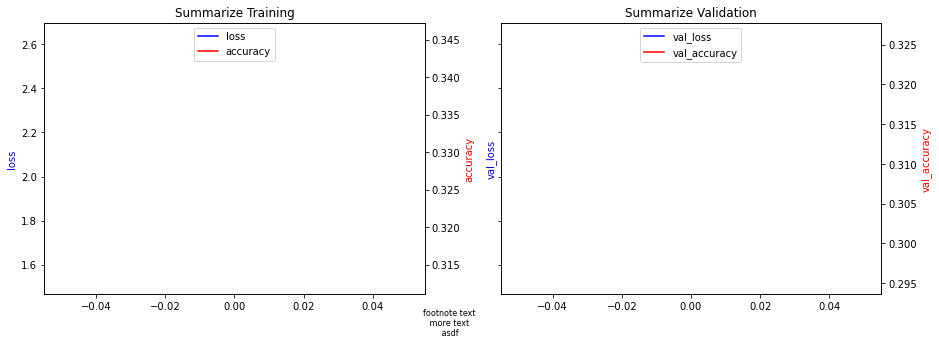

In [22]:
print(history.history.keys())
# summarize training
fig, (ax1,bx1), = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
l1, = ax1.plot(history.history['loss'], color='blue') 
ax2 = ax1.twinx()
l2, = ax2.plot(history.history['accuracy'], color='red')
ax1.set_ylabel('loss' , color='blue')
ax2.set_ylabel('accuracy', color='red' )
plt.legend([l1, l2], ["loss","accuracy" ], loc="upper center")
plt.xlabel('epochs')
plt.title('Summarize Training')
plt.figtext(0.5, 0.01, 'footnote text\n more text \n asdf', horizontalalignment='center', fontsize=8)
# plt.show()

# summarize validation
# fig, ax1 = plt.subplots()
l1, = bx1.plot(history.history['val_loss'], color='blue') 
bx2 = bx1.twinx()
l2, = bx2.plot(history.history['val_accuracy'], color='red')
bx1.set_ylabel('val_loss' , color='blue')
bx2.set_ylabel('val_accuracy', color='red' )
plt.legend([l1, l2], ["val_loss","val_accuracy" ], loc="upper center")
plt.xlabel('epochs')
plt.title('Summarize Validation')
plt.show()



In [25]:
predictions = model.predict(val_data_generator) 

 2/70 [..............................] - ETA: 17:40

KeyboardInterrupt: 

##### EXTRACT FEATURES USING THE PRETRAINED CNN

In [ ]:
#Send test data through the model to get the output values
X_test_feature = model.predict(x_test)

# X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

In [ ]:
X_test_feature[:9],X_test_feature.shape
flattened = X_test_feature.argmax(axis=1)

MAKE A RANDOM FOREST LAYER

In [ ]:

RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

# Train the model on training data
RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

In [ ]:
#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_RF = label_encoder.inverse_transform(prediction_RF)

In [24]:
#Print overall accuracy
accuracy = metrics.accuracy_score(test_labels, prediction_RF)
print ("Accuracy = ", accuracy)

NameError: name 'test_labels' is not defined

In [23]:
# from sklearn.metrics import confusion_matrix
#Confusion Matrix - verify accuracy of each class
cm = metrics.confusion_matrix(test_labels, prediction_RF)
#print(cm)
heatmap =sns.heatmap(cm, annot=True)

NameError: name 'test_labels' is not defined

In [ ]:

#Save confusion matrix
heatmap.get_figure().savefig(f"confusion_matrices/{getTimeStamp()}_VGG16-RF_cats{cm.shape[0]}-{MAX_NUMBER_OF_EACH_FINDING}-{NUMBER_OF_EACH_FINDING_RESERVED_FOR_TESTING}_size{SIZE}_acc{round(accuracy,2)}.png")

In [ ]:
#Check results on a few select images
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction_RF = RF_model.predict(input_img_features)[0] 
prediction_RF = label_encoder.inverse_transform([prediction_RF])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_RF)
print("The actual label for this image is: ", test_labels[n])